### Data and Imports

In [1]:
# Styling
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:70% !important; }</style>"))

# Data imports
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 40)

dc = pd.read_csv('data/incident_event_log.csv',sep=',')
dc.head(6)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00
5,INC0000047,Active,True,1,0,1,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 21,29/2/2016 05:30,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 24,Resolver 31,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


### Feature Engineering

In [2]:
# Une copie du dataframe n'est jamais une mauvaise idée.
# Cela evite que les données se suppriment definitivement.
df = dc.copy()

# On remarque que dans le dataframe, plusieurs lignes ont le meme numero(id)
# Ceci est du aux mises à jours que les gestions d'erreurs ont subi.
# J'ai pris le choix de laisser la derniere ligne uniquement.
df.drop_duplicates(subset ="number", keep = "last", inplace = True)

## Choix des colonnes a traiter
# Avec toutes les colonnes possibles à traiter, il se doit de faire un choix (judicieux, certes)
# Pour eviter de surcharger les bases d'entrainements et de garder un miminum de sens dans la methode de travail. 
#(AKA: Ne pas y aller en mode bourrin)
df = df[['incident_state','category','u_symptom',
         'active','reassignment_count','reopen_count','sys_mod_count',
         'made_sla','knowledge','u_priority_confirmation','opened_at','closed_at']]


## One hot encoding
# Tres utile dans notre cas. Il faut savoir que les variables categorielles sont très presentes.
# Pour pouvoir les traiter, on crée une nouvelle colonne, ayant pour titre la categorie en elle meme,
# Toutes les lignes verifiant ainsi cette categorie se verront attribuer un 1 à la cellule appropriée un 0 sinon.
oneHotCol = ['incident_state','category','u_symptom']
for col in oneHotCol:
    # use pd.concat to join the new columns with the original dataframe
    df = pd.concat([df,pd.get_dummies(df[col], prefix=col)],axis=1)

    # drop the original 'col' column
    df.drop([col],axis=1, inplace=True)
    
    
    
# Conversion des textes en format datetime : facilite le traitement des durées juste apres
df['opened_at'] = pd.to_datetime(df['opened_at'],
                                     infer_datetime_format=True,
                                     errors='coerce')
df['closed_at'] = pd.to_datetime(df['closed_at'],
                                     infer_datetime_format=True,
                                     errors='coerce')
# Traitement des durées 
df['wait']=df['closed_at']-df['opened_at']

# La colonne f_wait contiendra le nombres de jours d'attente avant la fin de l'incident    
df['f_wait'] = df['wait'].dt.total_seconds() / (24 * 60 * 60)
df= df.drop(columns=['wait','opened_at','closed_at'])

# Removeing values where there is no time difference
df.drop(df[(df.f_wait).isnull()].index, inplace=True)

# Removing all the possible negative features
for column in df.columns:
    s = str(column)
    df = df.drop(df[df[s] < 0].index)

### Machine Learning

In [3]:
# Importing the libraries
import matplotlib.pyplot as plt

# Modeling selection 

# Defining X and y 
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

#### Testing Chi-2

In [4]:
# Load libraries 
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Create features and target 
y=y.astype(int)

# Two features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k = 50) 
X_kbest_features = chi2_features.fit_transform(X, y) 

print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

X = X_kbest_features

Original feature number: 459
Reduced feature number: 50


/Users/hanyakoury/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


#### Data Split

In [5]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 2)

# Standard Scaling
from sklearn.preprocessing import StandardScaler
scaler   = StandardScaler().fit(X_train)
X_train  = scaler.transform(X_train)
X_test   = scaler.transform(X_test)

#### Models

In [6]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
reg_lineaire = LinearRegression()
reg_lineaire.fit(X_train, y_train)

# TreeClassifier regressor
from sklearn.tree import DecisionTreeRegressor
reg_arbre = DecisionTreeRegressor(max_depth=4)
reg_arbre.fit(X, y)

# Tree with AdaBoost
from sklearn.ensemble import AdaBoostRegressor
reg_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=np.random.RandomState(1))
reg_ada.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=300,
                  random_

### Score function

In [7]:
# Machine Learning function that returns multiple 'scores' and 'losses'

def get_score(algorithme, X_train, X_test, y_train, y_test, display_graph=False, display_options=True):
    
    if display_options:
        print("fitting: "+ str(algorithme))
        print("X_train:{} , X_test:{} ,  y_train:{} ,  y_test:{}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
        
    modele = algorithme.fit(X_train, y_train)
    yhat = algorithme.predict(X_test)
    
    # functions
    def adj_r2(model,y,yhat):
        from sklearn import metrics
        adj = 1 - float(len(y)-1)/(len(y)-(len(model.coef_)-1)-1)*(1 - metrics.r2_score(y,yhat))
        return adj
    
    # Adjusted R2
    score = "adjusted R2: " + str(adj_r2(reg_lineaire,y_test,yhat))
    
    # RMSE (Rooted mean squared error)
    from sklearn.metrics import mean_squared_error
    loss = test_rmse = "rmse: "+ str(np.sqrt(mean_squared_error(y_test, yhat)))
    
    # Kfold Cross Accuracy
    from sklearn.model_selection import cross_val_score
    kfold_accuracy = cross_val_score(reg_lineaire, X_test, y_test, cv=4)
    
    ## Scores
    scores =[]
    scores.append(score)
    scores.append(loss)
    if round(kfold_accuracy.mean()*100,2)>0.0:
        scores.append("kfold-cross : Accuracy: %0.2f (+/- %0.2f)" % (round(kfold_accuracy.mean()*100,2), kfold_accuracy.std() * 2))
    else:
        scores.append("kfold-cross : Accuracy: Na")
    
    if display_graph:
        import matplotlib.pyplot as plt
        plt.scatter(y_test, yhat) ## Predictions against True values
        plt.xlabel=('y test')
        plt.ylabel=('y hat')
        plt.show()
    return scores

#### Tests

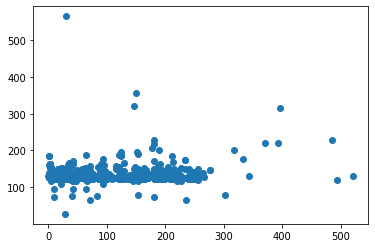

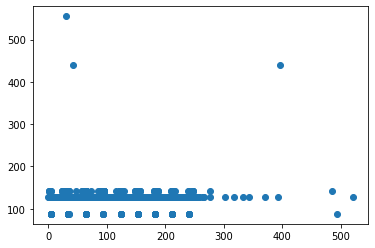

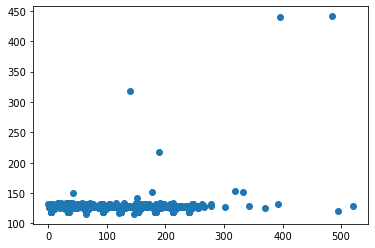

LinearRegression
['adjusted R2: -0.03791501069615921', 'rmse: 73.11362150703322', 'kfold-cross : Accuracy: Na']
DecisionTreeRegr
['adjusted R2: -0.03039510018148972', 'rmse: 72.84827830566391', 'kfold-cross : Accuracy: Na']
AdaBoostRegresso
['adjusted R2: 0.000156168736511475', 'rmse: 71.7601743899724', 'kfold-cross : Accuracy: Na']


In [8]:
models = [reg_lineaire,reg_arbre,reg_ada]
results=[]

for mod in models:
    stri = str(mod)[0:16]
    results.append(stri)
    results.append(get_score(mod,X_train, X_test, y_train, y_test, display_graph=True, display_options=False))

for result in results:
    print (result)